In [1]:
# Imports
import sys
import os

# Add the upstream directory to sys.path
upstream_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
if upstream_dir not in sys.path:
    sys.path.insert(0, upstream_dir)

import numpy as np
import matplotlib.pyplot as plt
import cv2
import glob
import paths
import json
from pygrabber.dshow_graph import FilterGraph
from multiprocessing import Process, Queue
import time
from microtissue_manipulator import camera, utils, core

In [ ]:
cap = camera.MultiprocessVideoCapture(0, width=640, height=480)
    
try:
    while True:
        ret, frame = cap.read()
        if ret:
            cv2.imshow('Multiprocess Video', frame)
            
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
        
        time.sleep(0.01)  # Small delay to prevent high CPU usage
finally:
    cap.release()
    cv2.destroyAllWindows()

# Camera class

In [8]:
CAMERA_LABELS_FILE = paths.CAM_CONFIGS_DIR + "/camera_labels.json"
CAMERA_CONFIG_DIR = paths.CAM_CONFIGS_DIR

class CameraManagerWindows:

    def __init__(self):
        self.graph = FilterGraph()
        self.devices = self.graph.get_input_devices()
        self.device_to_index = {name: idx for idx, name in enumerate(self.devices)}
        os.makedirs(CAMERA_CONFIG_DIR, exist_ok=True)
        self.label_map = self.load_labels()

    def load_labels(self):
        if os.path.exists(CAMERA_LABELS_FILE):
            with open(CAMERA_LABELS_FILE, "r") as f:
                return json.load(f)
        else:
            with open(CAMERA_LABELS_FILE, "w") as f:
                json.dump({}, f, indent=4)
            return {}

    def save_labels(self):
        with open(CAMERA_LABELS_FILE, "w") as f:
            json.dump(self.label_map, f, indent=4)

    def assign_label(self, device_name, label):
        if device_name not in self.devices:
            raise ValueError(f"Device '{device_name}' not found.")
        self.label_map[label] = device_name
        self.save_labels()
        self.load_resolution_config(label)

    def list_devices(self):
        return self.devices

    def list_labels(self):
        return self.label_map

    def get_camera_index_by_label(self, label):
        device_name = self.label_map.get(label)
        if device_name is None:
            raise ValueError(f"Label '{label}' not found.")
        index = self.device_to_index.get(device_name)
        if index is None:
            raise RuntimeError(f"Device '{device_name}' is not connected.")
        return index

    def get_config_path(self, label):
        return os.path.join(CAMERA_CONFIG_DIR, f"{label}.json")

    def load_resolution_config(self, label):
        config_path = self.get_config_path(label)
        if os.path.exists(config_path):
            with open(config_path, "r") as f:
                return json.load(f)
        else:
            empty = {"resolutions": [], "default_resolution": None}
            with open(config_path, "w") as f:
                json.dump(empty, f, indent=4)
            return empty

    def save_resolution_config(self, label, resolutions):
        config_path = self.get_config_path(label)
        with open(config_path, "w") as f:
            json.dump({"resolutions": resolutions}, f, indent=4)

In [ ]:
cam_manager = CameraManagerWindows()
print("Connected cameras:")
for i, name in enumerate(cam_manager.list_devices()):
    print(f"  [{i}] {name}")

label = "underview_cam"  # Example label for the under-view camera
index = cam_manager.get_camera_index_by_label(label)
resolution = cam_manager.load_resolution_config(label)['default_resolution']
under_captupe = camera.MultiprocessVideoCapture(cam_manager.get_camera_index_by_label(label), width=resolution[0], height=resolution[1])

label = "overview_cam"  # Example label for the under-view camera
index = cam_manager.get_camera_index_by_label(label)
resolution = cam_manager.load_resolution_config(label)['default_resolution']
over_capture = camera.MultiprocessVideoCapture(cam_manager.get_camera_index_by_label(label), width=resolution[0], height=resolution[1])

Connected cameras:
  [0] Arducam B0478 (USB3 48MP)
  [1] HD USB Camera


In [12]:
cam_manager.load_resolution_config("underview_cam")['default_resolution']

[3840, 2160]

In [11]:
cam_manager.assign_label('Arducam B0478 (USB3 48MP)', "underview_cam")
cam_manager.assign_label("HD USB Camera", "overview_cam")

In [19]:
cv2.namedWindow("video", cv2.WINDOW_NORMAL)
cv2.resizeWindow("video", 1348, 1011)

capture = under_captupe
if not capture.is_opened():
    print("Error: Could not open video stream.")
else:
    print("Streaming video. Press 'q' to quit.")
    while True:
        ret, frame = capture.read()

        cv2.imshow("video", frame)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

capture.release()
cv2.destroyAllWindows()

Error: Could not open video stream.


In [30]:
cam_mgr = CameraManagerWindows()
cam = CameraCapture(cam_mgr, "overview_cam")

cam.start()  # uses default resolution
# Or: cam.start((1280, 720))

try:
    while True:
        frame = cam.get_frame()
        if frame is not None:
            cv2.imshow("Camera Stream", frame)
        else:
            print("No frame available.")

        if cv2.waitKey(1) == ord("q"):
            break
finally:
    cam.stop()
    cv2.destroyAllWindows()

No frame available.
No frame available.
No frame available.
No frame available.
No frame available.
No frame available.
No frame available.
No frame available.
No frame available.
No frame available.
No frame available.
No frame available.
No frame available.
No frame available.
No frame available.
No frame available.
No frame available.
No frame available.
No frame available.
No frame available.
No frame available.
No frame available.
No frame available.
No frame available.
No frame available.
No frame available.
No frame available.
No frame available.
No frame available.
No frame available.
No frame available.
No frame available.
No frame available.
No frame available.
No frame available.
No frame available.
No frame available.
No frame available.
No frame available.
No frame available.
No frame available.
No frame available.
No frame available.
No frame available.
No frame available.
No frame available.
No frame available.
No frame available.
No frame available.
No frame available.


KeyboardInterrupt: 

# Other stuff

In [61]:
# background = cv2.imread('../outputs/images/2025-04-21_underneath_camera_test/frame_2025_04_24_15-40-16.png')
# cuboids = cv2.imread('../outputs/images/2025-04-21_underneath_camera_test/frame_2025_04_24_15-21-57.png')

cuboids = cv2.imread('../outputs/images/underneath_dataset/saved_frame_20250424_155117.png')
background = cv2.imread('../outputs/images/underneath_dataset/saved_frame_20250424_155042.png')

In [136]:
def focus_map(img, ksize=15):
    lap = cv2.Laplacian(img, cv2.CV_64F)
    var = cv2.blur(lap**2, (ksize, ksize))  # Local variance
    return var

In [159]:
cap = cv2.VideoCapture(0)  # 0 is the default camera
if not cap.isOpened():
    print("Error: Could not open video capture.")
else:
    print("Video capture opened successfully.")
    cap.set(cv2.CAP_PROP_FRAME_WIDTH, 2000)
    cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 1500)
    cap.set(cv2.CAP_PROP_FOURCC, cv2.VideoWriter_fourcc(*'YUY2'))

cv2.namedWindow("video", cv2.WINDOW_NORMAL)
cv2.resizeWindow("video", 1348, 1011)

def set_focus(val):
    cap.set(cv2.CAP_PROP_FOCUS, val)
set_focus(900)

gray_bg = cv2.cvtColor(background, cv2.COLOR_BGR2GRAY)



while(True):
    # Capture frame-by-frame
    ret, frame = cap.read()
    frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    mask = np.zeros_like(frame_gray, dtype=np.uint8)
    circle_center = (int(frame.shape[1] / 2), int(frame.shape[0] / 2))
    circle_radius = 425
    cv2.circle(mask, circle_center, circle_radius, (255, 255, 255), -1)

    focus = focus_map(frame_gray)
    _, focus_mask = cv2.threshold(focus, 75, 255, cv2.THRESH_BINARY)
    focus_mask = np.uint8(focus_mask)

    masked_frame = cv2.bitwise_and(frame_gray, mask)
    focus_masked = cv2.bitwise_and(masked_frame, focus_mask)

    # thresh = cv2.adaptiveThreshold(focus_masked, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,25,4) 
    thresh = cv2.threshold(focus_masked, 25, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
    thresholded = cv2.bitwise_and(frame_gray, thresh)

    contours, hei = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    # hierarchy = hei[0]

    # # Find innermost contours (no children)
    # innermost_contours = [contours[i] for i in range(len(contours)) if hierarchy[i][2] == -1]
    # filtered_contours = [contour for contour in contours if 300 < cv2.contourArea(contour) < 1500]
    plot_img = frame.copy()
    cv2.circle(plot_img, circle_center, circle_radius, (0, 255, 0), 2)
    _ = cv2.drawContours(plot_img, contours, -1, (0, 0, 255), 2)


    cv2.imshow('video', focus_mask)
    k = cv2.waitKey(1) & 0xFF

    if k == ord('q'):
        break

# When everything done, release the capture
cap.release()
cv2.destroyAllWindows()

Video capture opened successfully.


# Old

In [11]:
frame = cv2.imread('../outputs/images/segmentation_test/frame_2025_04_09_16-36-42.png')

In [93]:
# Convert to grayscale
gray_img = cv2.cvtColor(cuboids, cv2.COLOR_BGR2GRAY)
gray_bg = cv2.cvtColor(background, cv2.COLOR_BGR2GRAY)

# Subtract background
diff = cv2.absdiff(gray_img, gray_bg)

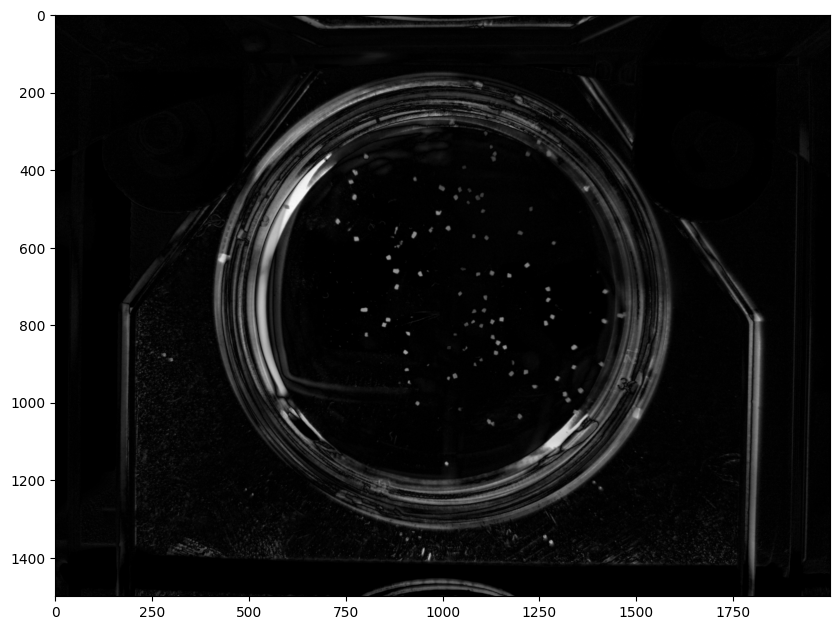

In [69]:
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(diff, cv2.COLOR_BGR2RGB))    

In [131]:
frame = diff
mask = np.zeros_like(frame, dtype=np.uint8)
circle_center = (int(frame.shape[1] / 2), int(frame.shape[0] / 2))
circle_radius = 425
minimum_distance = 2
cv2.circle(mask, circle_center, circle_radius, (255, 255, 255), -1)
masked_frame = cv2.bitwise_and(frame, mask)

blur = cv2.GaussianBlur(masked_frame, (11, 11), 0)
focus_masked = cv2.bitwise_and(blur, focus_mask)
thresh = cv2.adaptiveThreshold(focus_masked, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY_INV,25,4) 
# thresh = cv2.bitwise_and(thresh, mask)
# kernel = np.ones((5,5),np.uint8)
# thresh = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)
# mask_inv = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)

contours, hei = cv2.findContours(t, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
# hierarchy = hei[0]

# # Find innermost contours (no children)
# innermost_contours = [contours[i] for i in range(len(contours)) if hierarchy[i][2] == -1]
# filtered_contours = [contour for contour in contours if 300 < cv2.contourArea(contour) < 1500]
plot_img = cuboids.copy()
cv2.circle(plot_img, circle_center, circle_radius, (0, 255, 0), 2)
_ = cv2.drawContours(plot_img, contours, -1, (0, 0, 255), 2)

(-0.5, 1999.5, 1499.5, -0.5)

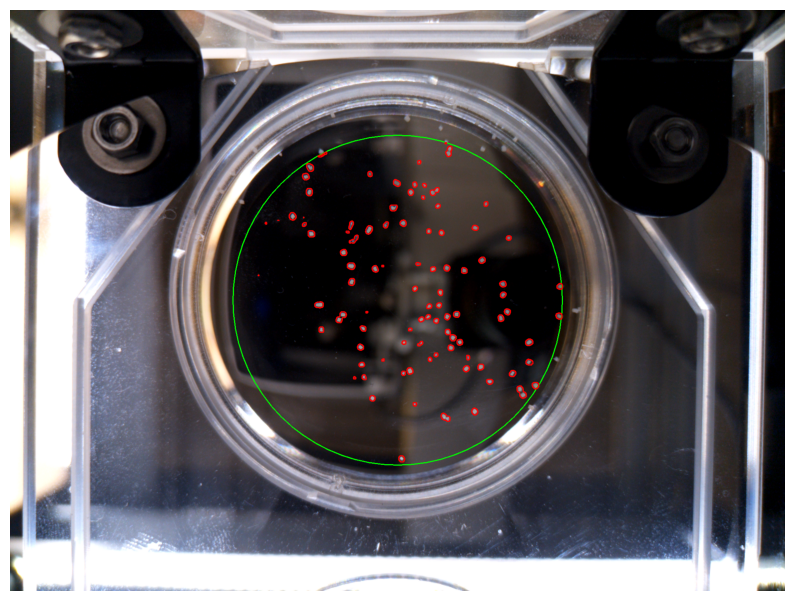

In [132]:
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(plot_img, cv2.COLOR_BGR2RGB))
plt.axis('off')    

(-0.5, 1999.5, 1499.5, -0.5)

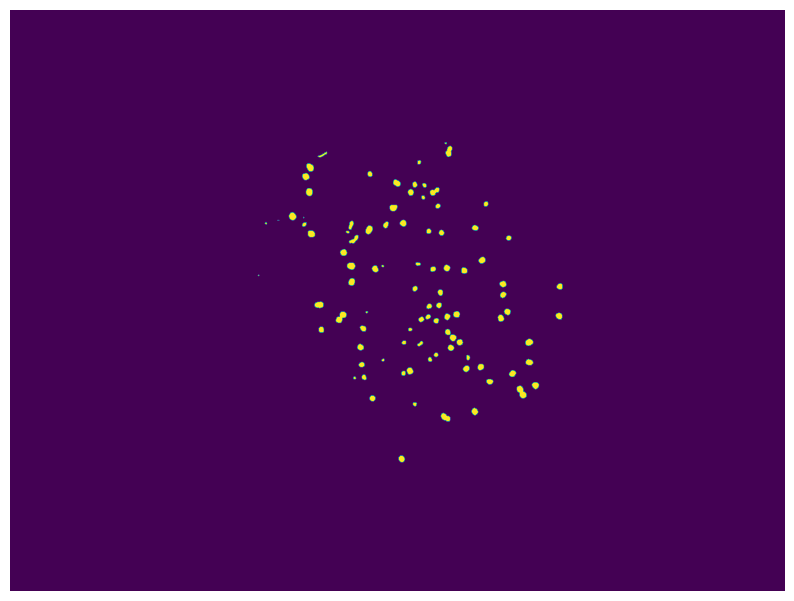

In [130]:
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(focus_masked, cv2.COLOR_BGR2RGB))
_, t = cv2.threshold(focus_masked, 15, 255, cv2.THRESH_BINARY)
plt.imshow(t)

plt.axis('off')    

In [30]:
calibration_data = utils.load_calibration_config('checkerboard')
tf_mtx = np.array(calibration_data['tf_mtx'])
calib_origin = np.array(calibration_data['calib_origin'])[:2]
offset = np.array(calibration_data['offset'])
size_conversion_ratio = calibration_data['size_conversion_ratio']
one_d_ratio = calibration_data['one_d_ratio']

In [ ]:
cr = core.Core()

In [26]:
cuboid_size_threshold = (400, 500)

In [57]:
mask = np.zeros_like(frame, dtype=np.uint8)
circle_center = (int(frame.shape[1] / 2), int(frame.shape[0] / 2))
circle_radius = 1000
minimum_distance = 2
cv2.circle(mask, circle_center, circle_radius + int(minimum_distance / one_d_ratio), (255, 255, 255), -1)
masked_frame = cv2.bitwise_and(frame, mask)

gray = cv2.cvtColor(masked_frame, cv2.COLOR_BGR2GRAY)
blur = cv2.GaussianBlur(gray, (11, 11), 0)
thresh = cv2.adaptiveThreshold(blur, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY_INV,47,2) 
kernel = np.ones((3,3),np.uint8)
thresh = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=1)
mask_inv = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
thresh = cv2.bitwise_and(thresh, mask_inv)

# Find contours in the masked frame
contours, hei = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
filtered_contours = [contour for contour in contours if 30 < cv2.contourArea(contour) < 1000]
cr.cuboids = filtered_contours
cr.cuboid_dataframe(cr.cuboids)

cuboid_size_micron2 = cr.cuboid_df.area * size_conversion_ratio * 1000000
cuboid_diameter = 2 * np.sqrt(cuboid_size_micron2 / np.pi)
dist_mm = cr.cuboid_df.min_dist * one_d_ratio
cr.cuboid_df['diameter_microns'] = cuboid_diameter
cr.cuboid_df['min_dist_mm'] = dist_mm
cr.cuboid_df['bubble'] = cr.cuboid_df.apply(lambda row: not bool(thresh[int(row['cY']), int(row['cX'])]), axis=1)
# bubble = bool(thresh[int(cub[1]), int(cub[0])])

# Filter out elongated contours
pickable_cuboids = cr.cuboid_df.loc[(cuboid_size_threshold[0] < cr.cuboid_df['diameter_microns']) & 
                                    (cr.cuboid_df['diameter_microns'] < cuboid_size_threshold[1]) &
                                    ((cr.cuboid_df['aspect_ratio'] > 0.75) | (cr.cuboid_df['aspect_ratio'] < 1.25)) &
                                    (cr.cuboid_df['circularity'] > 0.6) & (cr.cuboid_df['bubble'] != True)].copy()

# Check if cuboid centers are within the circle radius from the current circle center
pickable_cuboids['distance_to_center'] = pickable_cuboids.apply(
    lambda row: np.sqrt((row['cX'] - circle_center[0])**2 + (row['cY'] - circle_center[1])**2), axis=1
)
pickable_cuboids = pickable_cuboids[pickable_cuboids['distance_to_center'] <= circle_radius]
isolated = pickable_cuboids.loc[pickable_cuboids.min_dist_mm > minimum_distance]


In [ ]:
 def determine_pickable(row):
            cub = np.array((row.iloc[2], row.iloc[3]))
            contour = row.iloc[0]
            center = np.array(self.best_circ[:2])

            not_too_far = np.linalg.norm(cub-center) < self.best_circ[-1]-self.initial_offset-self.pickup_offset
            bubble = bool(self.thresh_fr[int(cub[1]), int(cub[0])])
            # cont_intensities = self.gray_fr.ravel()[np.ravel_multi_index(np.squeeze(contour).T, self.gray_fr.shape)]
            # bubble2 = self.gray_fr[int(cub[1]), int(cub[0])] < np.mean(cont_intensities)

            cX, cY = cub
            cX = int(cX)
            cY = int(cY)
            xs = np.squeeze(contour)[:,0]
            xs_min = np.min(xs)
            xs_max = np.max(xs)
            if self.gray_fr[cY,cX] - np.mean([self.gray_fr[cY, xs_min+1], self.gray_fr[cY, xs_max-1]]) > 5:
                bubble2 = False
            else:
                bubble2 = True

            # bubble2 = np.mean([self.gray_fr[cY, xs_min+1], self.gray_fr[cY, xs_max-1]]) > self.gray_fr[cY,cX]

            return bubble and not_too_far

In [51]:

plot_img = frame.copy()
cv2.circle(plot_img, circle_center, circle_radius + int(minimum_distance / one_d_ratio), (0, 0, 255), 2)
cv2.circle(plot_img, circle_center, circle_radius, (0, 255, 0), 2)
cv2.drawContours(plot_img, cr.cuboids, -1, (0, 0, 255), 2)
cv2.drawContours(plot_img, pickable_cuboids.contour.values.tolist(), -1, (0, 255, 255), 2)
cv2.drawContours(plot_img, isolated.contour.values.tolist(), -1, (0, 255, 0), 2)


array([[[127, 137, 134],
        [124, 134, 131],
        [125, 135, 132],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[124, 134, 131],
        [128, 138, 135],
        [128, 138, 135],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[126, 136, 133],
        [129, 139, 136],
        [127, 137, 134],
        ...,
        [ 75,  80,  79],
        [ 79,  85,  83],
        [ 79,  85,  83]],

       ...,

       [[  0,   0,   0],
        [  0,   0,   0],
        [ 10,  10,  10],
        ...,
        [125, 131, 136],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [ 14,  15,  15],
        ...,
        [ 74,  78,  81],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [ 19,  20,  20],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]]

In [50]:
pickable_cuboids

,contour,area,cX,cY,min_dist,aspect_ratio,circularity,diameter_microns,min_dist_mm,bubble,distance_to_center
45,"[[[1841, 1210]], [[1839, 1212]], [[1839, 1216]...",297.5,1848,1219,22.472205,1.444444,0.704042,421.709525,0.486920,False,604.742094
72,"[[[781, 709]], [[778, 712]], [[778, 714]], [[7...",298.5,786,721,41.629317,1.130435,0.613650,422.417686,0.902009,False,568.419739


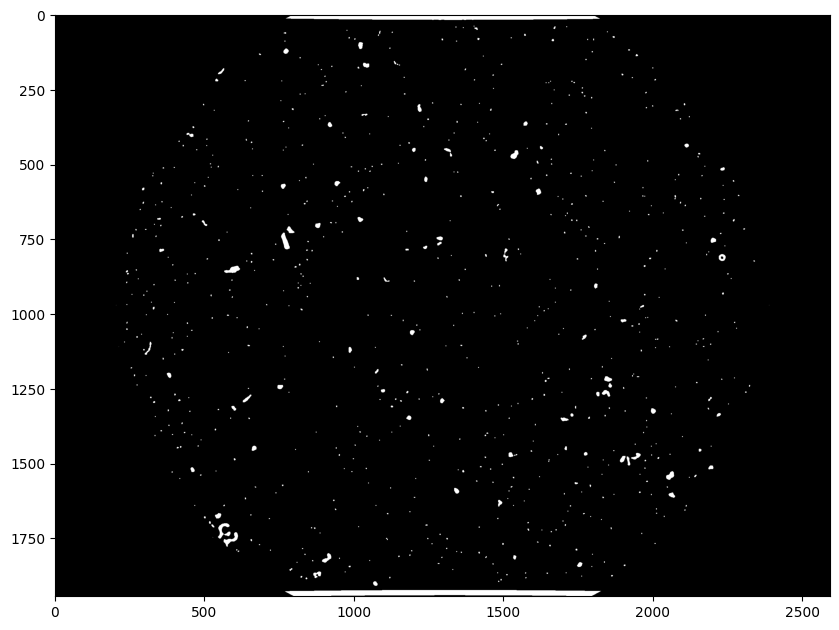

In [58]:
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(thresh, cv2.COLOR_BGR2RGB))   

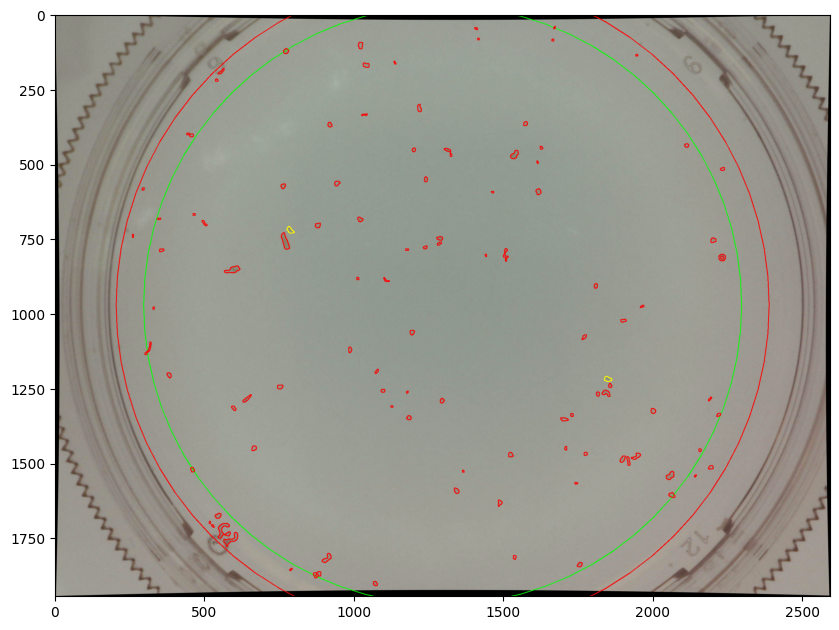

In [52]:
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(plot_img, cv2.COLOR_BGR2RGB))   

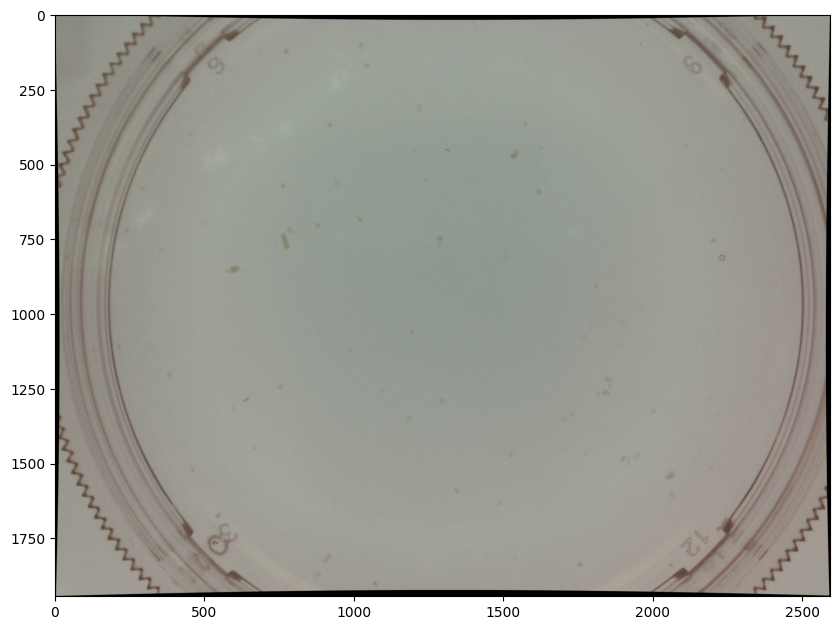

In [53]:
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))   